# Driver of LIM

## Import Modules

In [1]:
# import modules
import math
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from lim_mod import LIM

## Data

Reading from saved data ......
Use pressure levels = [   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]

t.shape = (21535,), y.shape = (21535, 37)
rank of inverted matrix =14
diagonal(vrH_vr)=
[1.0000001  1.0000001  1.         1.         1.         0.9999999
 0.9999999  0.9999999  0.9999999  1.         1.         1.
 0.99999994 0.99999994 0.9999999  0.9999999  0.9999999  1.0000002
 1.0000002  0.9999998  1.         1.         0.99999994 0.99999994
 1.         1.         1.0000001  0.99999994 0.99999994 1.0000002
 1.0000002  1.         0.99999976 1.         1.         0.9999998
 0.9999999 ]
norm(vlH - vlH @ vr @vlH) = 957.96484375
norm(vr - vr @ vlH @vr) = 60.33517074584961
norm(a - vr @ diag(w) @vlH) = 0.014921482652425766
rank of inverted matrix =37
diagonal(vrH_vr)=
[1.0000001  1.0000001  1.         1.         1

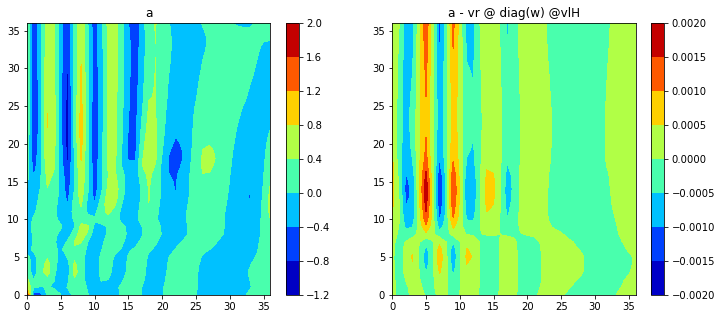

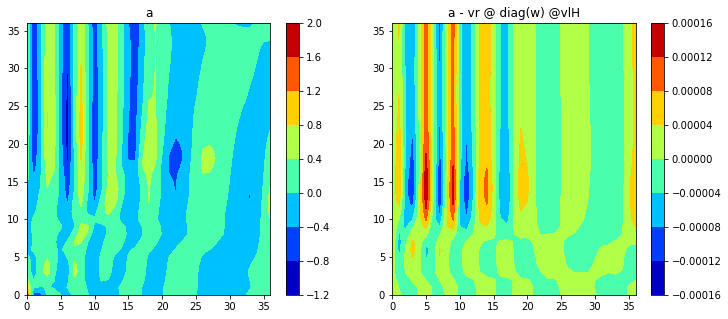

In [2]:
# data
if False:
    # red noise
    from ode_AM_index_config import get_red_noise as get_data
    gamma = [0.06]
    true_t, true_y = get_data(gamma=gamma, data_size=10000)
else:
    # annular mode
    from read_AM_index_mod import get_AM_index as get_data
    t, y, p = get_data()

print(f't.shape = {t.shape}, y.shape = {y.shape}')

# test of the method for eigen decomposition
# from lim_mod import cal_Gt, test_eig_m
# Gt = cal_Gt(y, 5, la_method='torch', verbose=True)
# test_eig_m(y, 5, la_method='torch')

## Model

In [ ]:
lag = 5
model = LIM(y, lag=lag, la_method='scipy', eig_method='eig2', verbose=True)

lag_time = 90
yf = model.forecast(y[:-lag_time], t[:lag_time+1])
print(f"\ny(t, x) ={y.shape}")
print(f"yf(lag, batch, x) = {yf.shape}")

## Plot the linear operator 

In [ ]:
val_time = 30
Ct = y[val_time:].T @ y[:-val_time] / (len(y)-val_time)
Ctf = yf[val_time,:,:].T @ yf[0,:,:] / yf.shape[1]
print(f"Ct = {Ct.shape}")
print(f"Ctf = {Ctf.shape}")

fig = plt.figure(figsize=(12,10))
cmax = 1
ax = fig.add_subplot(3,2,1)
plt.contourf(model.B.real, np.linspace(-cmax, cmax, 21))
plt.title('B (real)')
plt.colorbar()

ax = fig.add_subplot(3,2,2)
plt.contourf(model.B.imag)
plt.title('B (imag)')
plt.colorbar()

ax = fig.add_subplot(3,2,3)
plt.plot(model.vr.real[:,:2])
plt.title('vr')

ax = fig.add_subplot(3,2,4)
plt.plot(model.vl.real[:,:2])
plt.title('vl')

cmax = 0.5
ax = fig.add_subplot(3,2,5)
plt.contourf(Ct, np.linspace(-cmax, cmax, 21))
plt.title('Cov')
plt.colorbar()

ax = fig.add_subplot(3,2,6)
plt.contourf(Ctf, np.linspace(-cmax, cmax, 21))
plt.title('Cov (forecast)')
plt.colorbar()

## Plot autocovariance

In [ ]:
from plot_AM_index_mod import plot_cov

k = np.isin(p, 10).nonzero()[0][0]
plot_cov(y, yf=yf, k=k, lag_time=lag_time)


## Plot lagged covariance

In [ ]:
from plot_AM_index_mod import plot_lag_reg

plot_lag_reg(y, p, yf)

## Make composite for strong and weak vortex events


In [ ]:
from plot_AM_index_mod import plot_event

plot_event(y, p, yf=yf, lag_time=lag_time)